# COVID-CT Challenge

COVID-CT-Dataset: a CT scan dataset about COVID-19

https://covid-ct.grand-challenge.org/

# Imports

In [ ]:
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2
import os
from matplotlib import pyplot as plt
%matplotlib inline
from skimage.color import label2rgb
from skimage.filters import threshold_multiotsu
import numpy as np
import shutil
# !pip install pycuda pydicom
# import pycuda.autoinit 
# from pycuda import gpuarray
# from pycuda.compiler import SourceModule

     |████████████████████████████████| 28.2MB 105kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


#Step 1 - Download and unziping data

In [ ]:
!git clone https://github.com/UCSD-AI4H/COVID-CT/

%cd '/content/COVID-CT/Images-processed/'
! unzip -q -n CT_COVID.zip
! unzip -q -n CT_NonCOVID.zip
%cd '/content/COVID-CT/'

# constants
IMAGES_FOLDER = 'Images-processed'
DATA_SPLIT_FOLDER = 'Data-split'
MODEL_FOLDER = 'model'
DATASET_FOLDER = 'dataset'

# organize files in te following structure:

# /content/COVID-CT/dataset/
# /train
# ...covid/
# ......a_image_1.jpg
# ...non_covid/
# ......b_image_1.jpg
# /validation
# ...covid/
# ...non_covid/
# /test
# ...covid/
# ...non_covid/

# build dictionary with data split information
def load_datasplit():
    split_files = [
        {'filename': '{}/COVID/trainCT_COVID.txt'.format(DATA_SPLIT_FOLDER), 'object_type': 'train', 'class_type': 'covid'},
        {'filename': '{}/COVID/testCT_COVID.txt'.format(DATA_SPLIT_FOLDER), 'object_type': 'test', 'class_type': 'covid'},
        {'filename': '{}/COVID/valCT_COVID.txt'.format(DATA_SPLIT_FOLDER), 'object_type': 'validation', 'class_type': 'covid'},
        {'filename': '{}/NonCOVID/trainCT_NonCOVID.txt'.format(DATA_SPLIT_FOLDER), 'object_type': 'train', 'class_type': 'non_covid'},
        {'filename': '{}/NonCOVID/testCT_NonCOVID.txt'.format(DATA_SPLIT_FOLDER), 'object_type': 'test', 'class_type': 'non_covid'},
        {'filename': '{}/NonCOVID/valCT_NonCOVID.txt'.format(DATA_SPLIT_FOLDER), 'object_type': 'validation', 'class_type': 'non_covid'}        
    ]
    datasplit_dict = {}
    for item in split_files:
        datasplit_file = item['filename']
        file = open(datasplit_file, mode='r')
        text=file.read()
        file.close()
        loaded_dict = dict((k.strip(), {'object_type': item['object_type'], 
                                        'class_type': item['class_type']}) 
                            for k in text.split('\n'))
        datasplit_dict = {**datasplit_dict, **loaded_dict} 
    return datasplit_dict

folder_blacklist = []
contador = 0

# clean dataset folder to always have a fresh start
shutil.rmtree(DATASET_FOLDER, ignore_errors=True)

# creates data_split dictionary to know where to save files
data_split = load_datasplit()

# traverse dataset folders to do data preprocessing
counter = 0
for root, dirs, files in os.walk(IMAGES_FOLDER):
    path = root.split(os.sep)
    if ('__MACOSX' not in path):
        for file in files:
            if (file[-3:]=='jpg' or file[-3:]=='png'):
                source_path = '{}/{}'.format(root, file)
                contador = contador + 1
                object_type = data_split[file]['object_type'] # train, validation, test
                class_type = data_split[file]['class_type'] # covid / non_covid                
                target_folder = '{}/{}/{}'.format(DATASET_FOLDER, object_type, 
                                                   class_type)            
                target_path = '{}/{}'.format(target_folder, file)
                # for user feedback only
                print('.'.format(file), end=' ')
                if (contador % 100 == 0):
                    print('')
                os.makedirs(target_folder, exist_ok=True)
                shutil.move(source_path, target_path)
print('\nprocessed {} images'.format(contador))

Cloning into 'COVID-CT'...
remote: Enumerating objects: 5459, done.
remote: Total 5459 (delta 0), reused 0 (delta 0), pack-reused 5459
Receiving objects: 100% (5459/5459), 1.09 GiB | 46.41 MiB/s, done.
Resolving deltas: 100% (363/363), done.
Checking out files: 100% (1048/1048), done.
/content/COVID-CT/Images-processed
/content/COVID-CT
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

#Step 2 - Preprocessing data

[0.01568628 0.01568628 0.01568628]
(300, 412, 3)


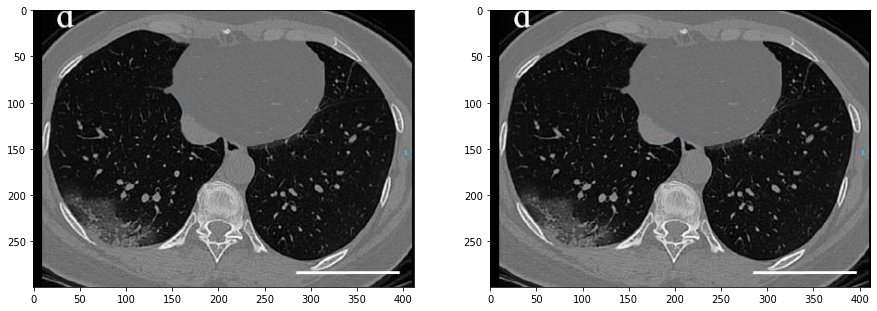

In [ ]:
NORMALIZATION = False
OTSU = False

# utility functions
def overlay_image(image_data, segmented_data):
    gray = image_data
    mask = segmented_data
    # adds segmented data overlay                              
    alpha = 0.6
    masked_image = np.dstack((gray, gray, gray))
    overlay = masked_image.copy()
    overlay[mask > 0] =  (0,255,0)
    cv2.addWeighted(overlay, alpha, masked_image, 1 - alpha, 0, masked_image)
    region_area = np.sum(mask)
    return masked_image

# preprocessing function
def preprocessing(src_image):
    image = src_image.copy()

    # 1. otsu limiarization to segment darker areas
    if (OTSU):
        thresholds = threshold_multiotsu(image, classes=2)
        regions = np.digitize(image, bins=thresholds)
        regions_colorized = label2rgb(regions)
        mask = np.zeros_like(regions)
        mask[regions==0]=1
        image[mask==0] = 0
        
    # 2. rescale
    image = np.true_divide(image.astype('float32'), 255)
    
    # # 2. run morphological operation to close small holes
    # krn = np.ones((10,0),np.uint8)
    # mask = np.uint8(mask)
    # mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, krn)

    # 3. normalizes image
    if (NORMALIZATION):
        # best practice (center pixels around dataset mean)
        # https://stats.stackexchange.com/questions/211436/why-normalize-images-by-subtracting-datasets-image-mean-instead-of-the-current
        dataset_mean = 0.45271412
        dataset_std = 0.33165374
        image = np.true_divide((image - dataset_mean), dataset_std) 

    return image


# test preprocessing
debug = True
image_path = '{}/train/covid/{}'.format(DATASET_FOLDER, '2020.02.24.20027052-p8-73%3.png')
image = cv2.imread(image_path, cv2.IMREAD_ANYCOLOR)
preprocessed = preprocessing(image)
print(preprocessed[20,20])
print(preprocessed.shape)

if (debug): 
    # overlay = overlay_image(image, mask)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
    ax1.imshow(image)
    ax2.imshow(preprocessed)

#Step 3 - Train model

total training covid images: 191
total training non_covid images: 234
total validation covid images: 60
total validation non_covid images: 58
--
Total training images: 425
Total validation images: 118
Total test images: 203
Found 425 images belonging to 2 classes.
Found 118 images belonging to 2 classes.


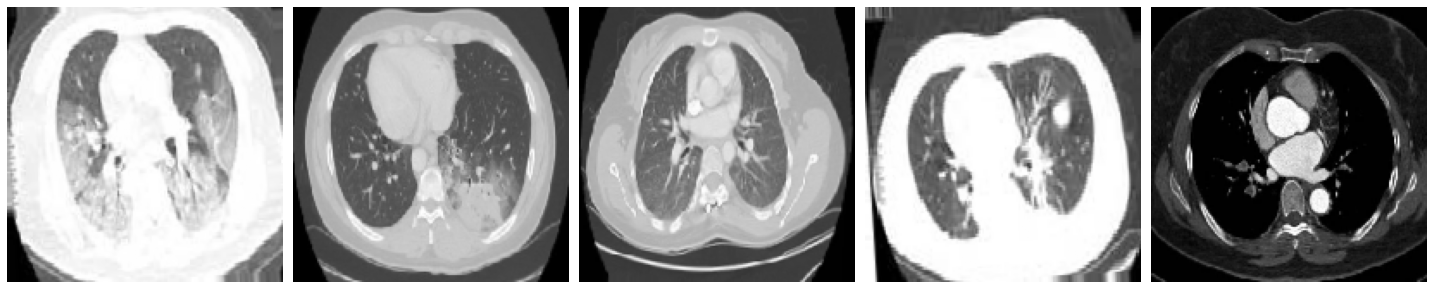

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 160, 160, 64) 1792        input_14[0][0]                   
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 160, 160, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 80, 80, 64)   0           block1_conv2[0][0]               
____________________________________________________________________________________________

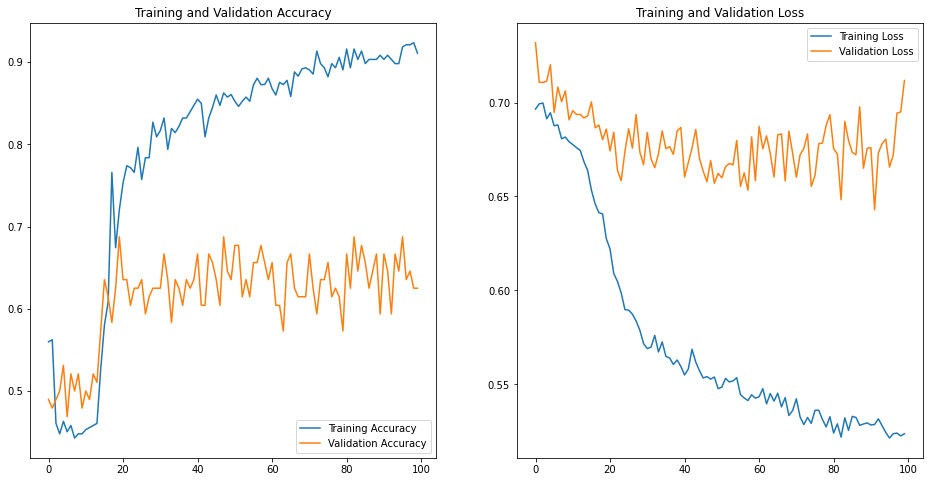

In [ ]:
# !ls preprocessed
import tensorflow as tf


from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

train_dir = '{}/train'.format(DATASET_FOLDER)
validation_dir = '{}/validation'.format(DATASET_FOLDER)
test_dir = '{}/test'.format(DATASET_FOLDER)

num_covid_tr = len(os.listdir(os.path.join(train_dir, 'covid') ))
num_non_covid_tr = len(os.listdir(os.path.join(train_dir, 'non_covid')))
num_covid_val = len(os.listdir(os.path.join(validation_dir, 'covid')))
num_non_covid_val = len(os.listdir(os.path.join(validation_dir, 'non_covid')))
num_covid_test = len(os.listdir(os.path.join(test_dir, 'covid')))
num_non_covid_test = len(os.listdir(os.path.join(test_dir, 'non_covid')))

total_train = num_covid_tr + num_non_covid_tr
total_val = num_covid_val + num_non_covid_val
total_test = num_covid_test + num_non_covid_test

print('total training covid images:', num_covid_tr)
print('total training non_covid images:', num_non_covid_tr)
print('total validation covid images:', num_covid_val)
print('total validation non_covid images:', num_non_covid_val)
print("--")

print("Total training images:", total_train)
print("Total validation images:", total_val)
print("Total test images:", total_test)

# total training images: 425
# total validation images: 108
# total test images: 203

epochs = 100
train_batch_size = 32
validation_batch_size = 32
steps_per_epoch = total_train // train_batch_size
validation_steps= total_val // validation_batch_size
IMG_SIZE= 160
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

basic_datagen = ImageDataGenerator(preprocessing_function=preprocessing)
augmented_datagen = ImageDataGenerator(preprocessing_function=preprocessing, rotation_range=0, horizontal_flip=False)

# load images from disk  
train_data_gen = augmented_datagen.flow_from_directory( batch_size=train_batch_size,
                                                            directory=train_dir,                                                    
                                                            shuffle=True,
                                                            target_size=(IMG_SIZE, IMG_SIZE),
                                                            color_mode='rgb',
                                                            class_mode='binary')


val_data_gen = basic_datagen.flow_from_directory(batch_size=validation_batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_SIZE, IMG_SIZE),
                                                              color_mode='rgb',
                                                              class_mode='binary')


sample_training_images, _ = next(train_data_gen)

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
plotImages(sample_training_images[:5])    

base_model = tf.keras.applications.VGG16(include_top=False, input_shape=IMG_SHAPE, weights='imagenet')
base_model.trainable = False

tower_1 = Conv2D(64, (1,1), padding='same', activation='relu')(base_model.output)
tower_1 = Conv2D(64, (3,3), padding='same', activation='relu')(tower_1)
tower_2 = Conv2D(64, (1,1), padding='same', activation='relu')(base_model.output)
tower_2 = Conv2D(64, (5,5), padding='same', activation='relu')(tower_2)
tower_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(base_model.output)
tower_3 = Conv2D(64, (1,1), padding='same', activation='relu')(tower_3)
module_1 = tf.keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)

tower_1 = Conv2D(64, (1,1), padding='same', activation='relu')(module_1)
tower_1 = Conv2D(64, (3,3), padding='same', activation='relu')(tower_1)
tower_2 = Conv2D(64, (1,1), padding='same', activation='relu')(module_1)
tower_2 = Conv2D(64, (5,5), padding='same', activation='relu')(tower_2)
tower_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(module_1)
tower_3 = Conv2D(64, (1,1), padding='same', activation='relu')(tower_3)
module_2 = tf.keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)

tower_1 = Conv2D(64, (1,1), padding='same', activation='relu')(module_2)
tower_1 = Conv2D(64, (3,3), padding='same', activation='relu')(tower_1)
tower_2 = Conv2D(64, (1,1), padding='same', activation='relu')(module_2)
tower_2 = Conv2D(64, (5,5), padding='same', activation='relu')(tower_2)
tower_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(module_2)
tower_3 = Conv2D(64, (1,1), padding='same', activation='relu')(tower_3)
module_3 = tf.keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)

# flat1 = Flatten()(module_3)
gap1 = GlobalAveragePooling2D()(module_3)

dense1 = Dense(256, activation='relu')(gap1)
dense2 = Dense(256, activation='relu')(dense1)
output = Dense(1, activation='sigmoid')(dense2)
# output = Activation("sigmoid")(dense2)
model = Model(inputs=base_model.inputs, outputs=output)
# summarize
model.summary()

base_learning_rate = 2e-5
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_data_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=validation_steps
)

os.makedirs(MODEL_FOLDER, exist_ok=True)
model.save('{}/mymodel'.format(MODEL_FOLDER))

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Step 4 - Evaluation

F1, AUC and Accuracy

In [ ]:
# TODO: Colocar as métricas adicionais.
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras import models

# test images: 203
batch_size = total_test
test_data_gen = basic_datagen.flow_from_directory(directory=test_dir,
                                            shuffle=False,
                                            batch_size=batch_size,
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            color_mode='rgb',
                                            seed=0,
                                            class_mode='binary')

model = models.load_model('{}/mymodel'.format(MODEL_FOLDER))

# predictions = model.predict(test_data_gen, steps=total_test//batch_size)
# print(predictions[0])

print("[INFO] evaluating network...")

scores = model.evaluate(test_data_gen, steps=total_test//batch_size)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

testy = test_data_gen.classes[test_data_gen.index_array]
# predict probabilities for test set
yhat_probs = model.predict(test_data_gen, steps=total_test//batch_size)
yhat_probs = yhat_probs[:, 0]
yhat_classes = np.zeros_like(yhat_probs).astype("int32")
yhat_classes[yhat_probs > 0.5] = 1

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testy, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testy, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testy, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testy, yhat_classes)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(testy, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(testy, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(testy, yhat_classes)
print(matrix)
# https://machinelearningmastery.com/how-to-calculate-precision-recall-f1-and-more-for-deep-learning-models/

model.summary()

Found 203 images belonging to 2 classes.
[INFO] evaluating network...
1/1 [==============================] - 0s 1ms/step - loss: 0.6259 - accuracy: 0.7389
accuracy: 73.89%
Accuracy: 0.738916
Precision: 0.740741
Recall: 0.761905
F1 score: 0.751174
Cohens kappa: 0.476677
ROC AUC: 0.804373
[[70 28]
 [25 80]]
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 160, 160, 64) 1792        input_14[0][0]                   
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 160, 160, 64) 36928       block1_conv1[0][0